# Omnigot One-Shot with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
import vbranch as vb
from vbranch.applications.resnet import ResNet18
from vbranch.utils.training_utils import wrap_iterator
from vbranch.utils.test_utils import get_run, compute_one_shot_acc, baseline_one_shot
from vbranch.losses import triplet

In [3]:
model_id = 1
architecture = 'res'

## Load Data

In [4]:
dataset = 'omniglot'

if dataset == 'omniglot':
    A, P, K = 4, 8, 4
    train_generator = vb.datasets.omniglot.load_generator('train')
    test_generator = vb.datasets.omniglot.load_generator('test')
elif dataset == 'market':
    P, K = 18, 4
    train_generator = vb.datasets.reid.TripletDataGenerator(dataset, 'train')

In [5]:
batch = train_generator.next(4, 4, 4, flatten=False, preprocess=False)

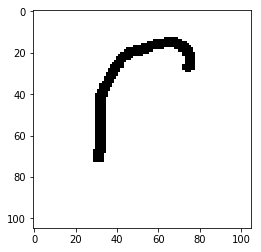

In [6]:
plt.imshow(batch[0, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [7]:
EPOCHS = 90
STEPS_PER_EPOCH = 100
T_0 = 30
output_dim = 128
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

NUM_BRANCHES = 2
SHARED_FRAC = 0.25

(None, 105, 105, 1)


In [8]:
if not os.path.isdir('./models'):
    os.system('mkdir models')

model_path = os.path.join('models', 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
    NUM_BRANCHES, SHARED_FRAC, model_id))

In [9]:
tf.reset_default_graph()

# Placeholder for feeding test images
x = tf.placeholder('float32', input_dim, name='x')
batch_size = tf.placeholder('int64', name='batch_size')

# train_datasets = []
# test_datasets = []
inputs = [None] * NUM_BRANCHES
train_init_ops = []
test_init_ops = []

for i in range(NUM_BRANCHES):
    train_dataset = tf.data.Dataset.from_generator(wrap_iterator(train_generator, A, P, K),
                                                   'float32', output_shapes=input_dim)
#     train_datasets.append(train_dataset)

    test_dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)
    
    iterator = tf.data.Iterator.from_structure('float32', input_dim)
    inputs[i] = iterator.get_next(name='input_'+str(i+1))    
    
    train_init = iterator.make_initializer(train_dataset)
    test_init = iterator.make_initializer(test_dataset, name='test_init_op_'+str(i+1))
    train_init_ops.append(train_init)
    test_init_ops.append(test_init)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [10]:
name = 'model_' + str(model_id)

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if architecture == 'simple':
        model = vb.simple_cnn(inputs, output_dim, 32, 64, 128, 256, 
                              name=name, shared_frac=SHARED_FRAC)
    elif architecture == 'res':
    #     model = vb.resnet(inputs, output_dim, 16, 32, 64, 
    #                       name='model_' + str(model_id))
        model = ResNet18(inputs, output_dim, name=name, shared_frac=SHARED_FRAC)

In [11]:
model.summary()

i   Layer name                      Output shape                     Num param  Inbound             
----------------------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                                
----------------------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                                
----------------------------------------------------------------------------------------------------
0   pre_conv (Conv2D)               [None,53,53,16] [None,53,53,48]  5600       input               
                                    [None,53,53,16] [None,53,53,48]                                 
----------------------------------------------------------------------------------------------------
1   pre_bn (BatchNormalization)     [None,53,53,16] [None,53,53,48]  224        pre_conv   

In [12]:
def lr_exp_decay_scheduler(init_lr, t0, t1, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / (t1 - t0))
        return lr
    return func

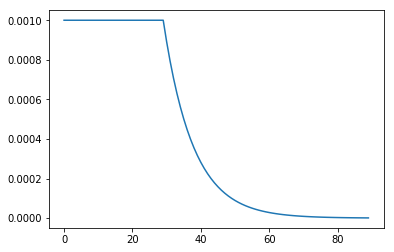

In [13]:
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [14]:
lr = tf.placeholder('float32', name='lr')
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# Compile model
model.compile(optimizer, 'triplet_omniglot', A=A, P=P, K=K)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_ops)

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        learning_rate = lr_scheduler(e + 1)
        for i in range(STEPS_PER_EPOCH):
            _, loss_values = sess.run([model.train_ops, model.losses], 
                                      feed_dict={lr:learning_rate})
            values = []
            for b in range(NUM_BRANCHES):
                key = 'loss_'+str(b+1)
                values.append(('loss_'+str(b+1), loss_values[key]))
            values += [('lr', learning_rate),]
            
            progbar.update(i + 1, values=values)
    
    saver = tf.train.Saver()
    path = os.path.join(model_path, 'ckpt')
    saver.save(sess, path)

Epoch 1/90
100/100 [==============================] - 114s 1s/step - loss_1: 213.4826 - loss_2: 218.1164 - lr: 0.0010
Epoch 2/90
 15/100 [===>..........................] - ETA: 37s - loss_1: 70.2732 - loss_2: 54.7227 - lr: 0.0010

## Model Ensemble

In [19]:
def restore_sess(sess, model_path):
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

In [20]:
def get_run(n_run):
    all_runs = 'omniglot/python/one-shot-classification/all_runs'
    
    if not os.path.isdir(all_runs):
        with zipfile.ZipFile(all_runs + '.zip','r') as zip_ref:
            zip_ref.extractall(all_runs)
    
    run_path = os.path.join(all_runs,'run%02d'%n_run,'class_labels.txt')
    with open(run_path) as f:
        content = f.read().splitlines()

    pairs = [line.split() for line in content]
    test_files  = [pair[0] for pair in pairs]
    train_files = [pair[1] for pair in pairs]

    answers_files = copy.copy(train_files)
    test_files.sort()
    train_files.sort()
    
    def f_load(f):
        path = os.path.join(all_runs, f)
        return cv2.imread(path)[..., 0]

    train_imgs = np.stack([f_load(f) for f in train_files]).\
                        astype('float32')[..., np.newaxis]
    test_imgs  = np.stack([f_load(f) for f in test_files]).\
                        astype('float32')[..., np.newaxis]

    return train_files, test_files, train_imgs, test_imgs, answers_files

In [21]:
def compute_one_shot_acc(test_pred, train_pred, train_files, answers_files):
    n_test = len(test_pred)
    n_train = len(train_pred)
    
    distM = np.zeros((n_test, n_train))
    for i in range(n_test):
        for c in range(n_train):
            distM[i,c] = distance.euclidean(test_pred[i],train_pred[c])
            
    YHAT = np.argmin(distM, axis=1)
    
    # compute the error rate
    correct = 0.0
    for i in range(n_test):
        if train_files[YHAT[i]] == answers_files[i]:
            correct += 1.0
        
    return correct / n_test

In [22]:
test_init_ops = ['test_init_op_'+str(i+1) for i in range(NUM_BRANCHES)]
model_outputs = ['model_1/output_vb{}:0'.format(i+1) for i in range(NUM_BRANCHES)]

In [23]:
total_runs = 20
train_pred_runs = []
test_pred_runs = []

run_data = [get_run(r+1) for r in range(total_runs)]

with tf.Session() as sess:
    restore_sess(sess, model_path)

    for r in range(total_runs):
        train_files,test_files,train_imgs,test_imgs,answers_files = run_data[r]

        feed_dict = {'x:0':train_imgs, 'batch_size:0':len(train_imgs)}
        sess.run(test_init_ops, feed_dict=feed_dict)
        train_pred_runs.append(sess.run(model_outputs))

        feed_dict = {'x:0':test_imgs, 'batch_size:0':len(test_imgs)}
        sess.run(test_init_ops, feed_dict=feed_dict)
        test_pred_runs.append(sess.run(model_outputs))

INFO:tensorflow:Restoring parameters from models/vb-omniglot-simple-B3-S0.00_1/ckpt


### Average Embedding

In [24]:
mean_acc_runs = []
for r in range(total_runs):
    test_embed = np.mean(test_pred_runs[r], axis=0)
    train_embed = np.mean(train_pred_runs[r], axis=0)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    mean_acc_runs.append(acc)

In [25]:
print(mean_acc_runs)
print(np.mean(mean_acc_runs))

[0.85, 0.75, 0.95, 0.9, 0.9, 0.9, 0.9, 0.75, 0.75, 0.75, 1.0, 0.8, 0.7, 0.8, 0.95, 1.0, 0.8, 0.9, 0.6, 0.7]
0.8325000000000001


### Concatenate Embedding

In [26]:
concat_acc_runs = []
for r in range(total_runs):
    test_embed = np.concatenate(test_pred_runs[r], axis=-1)
    train_embed = np.concatenate(train_pred_runs[r], axis=-1)
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
        
    acc = compute_one_shot_acc(test_embed, train_embed,train_files, answers_files)
    concat_acc_runs.append(acc)

In [27]:
print(concat_acc_runs)
print(np.mean(concat_acc_runs))

[0.85, 0.7, 0.95, 0.9, 0.95, 0.9, 0.9, 0.7, 0.8, 0.8, 1.0, 0.85, 0.7, 0.75, 1.0, 1.0, 0.9, 0.95, 0.7, 0.8]
0.8550000000000001
